C:\Users\Bert\AppData\Local\Temp\ipykernel_17880\62809983.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize()
C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be igno

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Bert\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


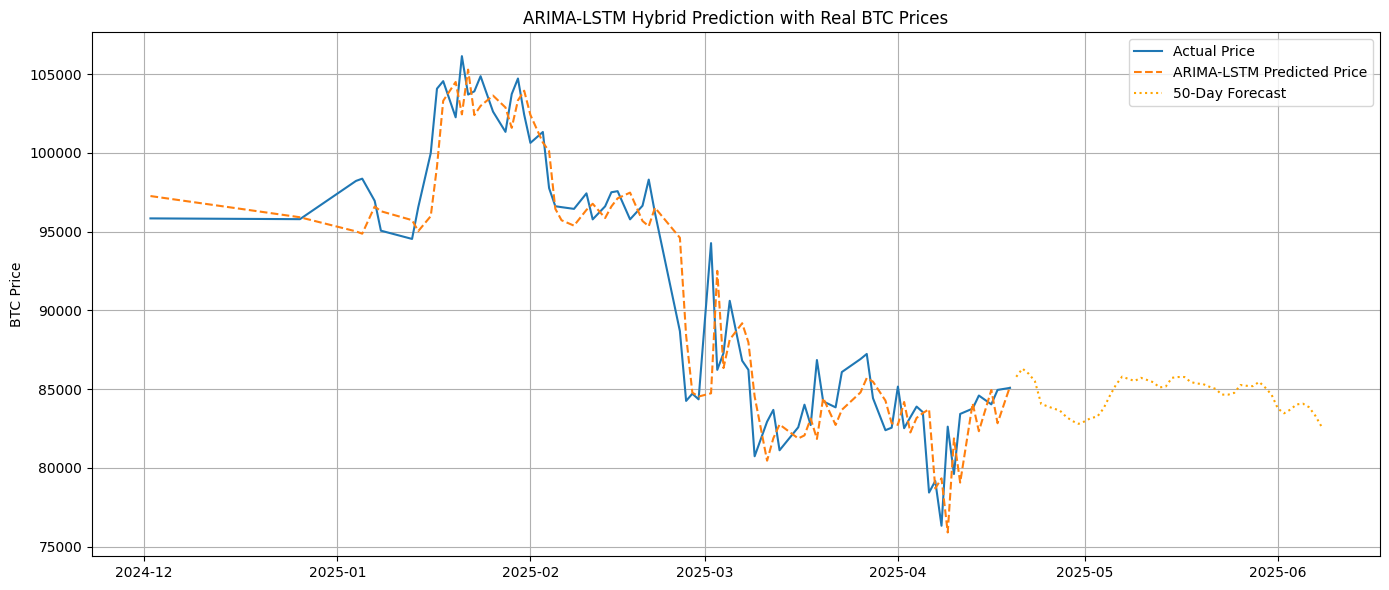

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and preprocess data
df = pd.read_csv("dataset/bitcoin_sentiment.csv")
df['published_date'] = pd.to_datetime(df['published_date']).dt.normalize()
df.sort_values('published_date', inplace=True)

# Use actual BTC prices from dataset
df['price_btc'] = df['price_btc'].astype(float)

# Clean sentiment mapping
df['sentiment_score'] = df['sentiment'].map({
    'positive': 1,
    'neutral': 0,
    'negative': -1
}).fillna(0)

# Aggregate by date
daily_df = df.groupby('published_date').agg({
    'sentiment_score': 'mean',
    'price_btc': 'mean'
}).reset_index()
daily_df.set_index('published_date', inplace=True)

# Fit ARIMA model
price_series = daily_df['price_btc']
arima_model = ARIMA(price_series, order=(1, 1, 1))
arima_result = arima_model.fit()
arima_pred = arima_result.predict(start=1, end=len(price_series)-1, typ='levels')
residuals = price_series[1:] - arima_pred

# Prepare features for LSTM
lstm_df = daily_df.iloc[1:].copy()
lstm_df['residual'] = residuals

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(lstm_df[['sentiment_score', 'residual']])

# Prepare sequences
X, y = [], []
seq_len = 5
for i in range(seq_len, len(scaled_features)):
    X.append(scaled_features[i-seq_len:i, 0:2])
    y.append(scaled_features[i, 1])
X, y = np.array(X), np.array(y)

# Build and train LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=100, batch_size=8, verbose=0)

# Predict residuals
predicted_residuals = model.predict(X)
temp = np.zeros((predicted_residuals.shape[0], 2))
temp[:, 1] = predicted_residuals[:, 0]
inv_residuals = scaler.inverse_transform(temp)[:, 1]

# Combine ARIMA + LSTM
final_arima = arima_pred.iloc[seq_len:].values
final_predicted_price = final_arima + inv_residuals

# Forecast future
future_days = 50
last_sentiment = daily_df['sentiment_score'].iloc[-1]

np.random.seed(42)
future_sentiments = [last_sentiment]
for _ in range(future_days - 1):
    next_val = future_sentiments[-1] + np.random.normal(0, 0.1)
    future_sentiments.append(np.clip(next_val, -1, 1))
future_sentiments = np.array(future_sentiments)

future_arima = arima_result.forecast(steps=future_days)

future_X = []
last_scaled = scaled_features[-seq_len:].copy()
for sentiment in future_sentiments:
    new_input = last_scaled.copy()
    new_input[:-1] = new_input[1:]
    new_input[-1, 0] = sentiment
    new_input[-1, 1] = 0
    future_X.append(new_input)
    last_scaled = new_input

future_X = np.array(future_X)
future_residuals = model.predict(future_X)

temp_future = np.zeros((future_residuals.shape[0], 2))
temp_future[:, 1] = future_residuals[:, 0]
inv_future_residuals = scaler.inverse_transform(temp_future)[:, 1]
future_price_pred = future_arima + inv_future_residuals

# Dates for forecast
last_date = daily_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(price_series.index[seq_len+1:], price_series.values[seq_len+1:], label='Actual Price')
plt.plot(price_series.index[seq_len+1:], final_predicted_price, label='ARIMA-LSTM Predicted Price', linestyle='--')
plt.plot(future_dates, future_price_pred, label='50-Day Forecast', linestyle=':', color='orange')
plt.title("ARIMA-LSTM Hybrid Prediction with Real BTC Prices")
plt.ylabel("BTC Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Validation of Training Model

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0175 - val_loss: 0.0214
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - val_loss: 0.0217
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - val_loss: 0.0222
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - val_loss: 0.0209
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0184 - val_loss: 0.0209
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - val_loss: 0.0209
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - val_loss: 0.0210
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0217 - val_loss: 0.0209
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0195 - val_loss: 0.0209
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - val_loss: 0.0209
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144 - val_los

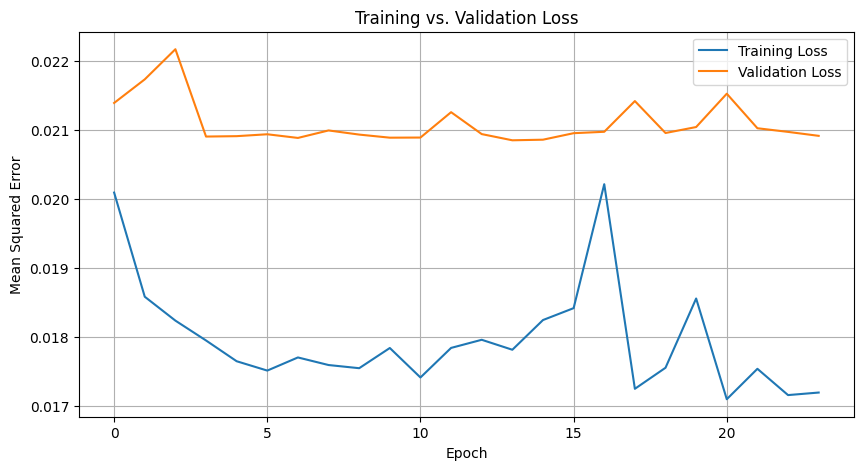

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Add EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with validation split
history = model.fit(
    X, y,
    epochs=100,
    batch_size=8,
    validation_split=0.2,  # 20% of data for validation
    callbacks=[early_stop],
    verbose=1
)
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
    print(f"Epoch {epoch}: Training Loss = {train_loss:.6f}, Validation Loss = {val_loss:.6f}")


Epoch 1: Training Loss = 0.020091, Validation Loss = 0.021388
Epoch 2: Training Loss = 0.018585, Validation Loss = 0.021729
Epoch 3: Training Loss = 0.018239, Validation Loss = 0.022165
Epoch 4: Training Loss = 0.017952, Validation Loss = 0.020902
Epoch 5: Training Loss = 0.017652, Validation Loss = 0.020907
Epoch 6: Training Loss = 0.017517, Validation Loss = 0.020935
Epoch 7: Training Loss = 0.017707, Validation Loss = 0.020882
Epoch 8: Training Loss = 0.017597, Validation Loss = 0.020990
Epoch 9: Training Loss = 0.017551, Validation Loss = 0.020930
Epoch 10: Training Loss = 0.017844, Validation Loss = 0.020885
Epoch 11: Training Loss = 0.017417, Validation Loss = 0.020887
Epoch 12: Training Loss = 0.017845, Validation Loss = 0.021254
Epoch 13: Training Loss = 0.017962, Validation Loss = 0.020937
Epoch 14: Training Loss = 0.017818, Validation Loss = 0.020848
Epoch 15: Training Loss = 0.018248, Validation Loss = 0.020856
Epoch 16: Training Loss = 0.018420, Validation Loss = 0.020950
E

In [4]:
print("Price data sample:")
print(daily_df['price_btc'].head(10))

print("\nARIMA predicted sample:")
print(arima_pred.head(10))

print("\nFinal predicted price sample:")
print(final_predicted_price[:10])

print("\nFuture predicted price sample:")
print(future_price_pred[:10]) # future_price_pred --> eto ung guide mo for getting the predicted price per day.


Price data sample:
published_date
2024-11-06    75571.99
2024-11-16    90586.92
2024-11-17    89855.99
2024-11-23    97672.40
2024-11-26    91965.16
2024-11-29    97460.00
2024-12-02    95840.62
2024-12-26    95791.60
2025-01-04    98220.50
2025-01-05    98363.61
Name: price_btc, dtype: float64

ARIMA predicted sample:
published_date
2024-11-16    82842.150788
2024-11-17    86527.632386
2024-11-23    93012.783332
2024-11-26    96102.648998
2024-11-29    92510.757820
2024-12-02    97720.503409
2024-12-26    95421.865855
2025-01-04    96123.954717
2025-01-05    98266.609750
2025-01-07    98344.887627
Name: predicted_mean, dtype: float64

Final predicted price sample:
[97259.99690558 95912.33774296 95015.83448338 94869.31684784
 96596.07233208 96295.10676274 95729.37179406 95034.6519275
 95983.57390875 99125.0996337 ]

Future predicted price sample:
84    85782.052280
85    86299.624125
86    85974.373675
87    85497.835457
88    84058.293203
89    83909.763234
90    83764.639706
91    83

# Sentiment - Record (Values)

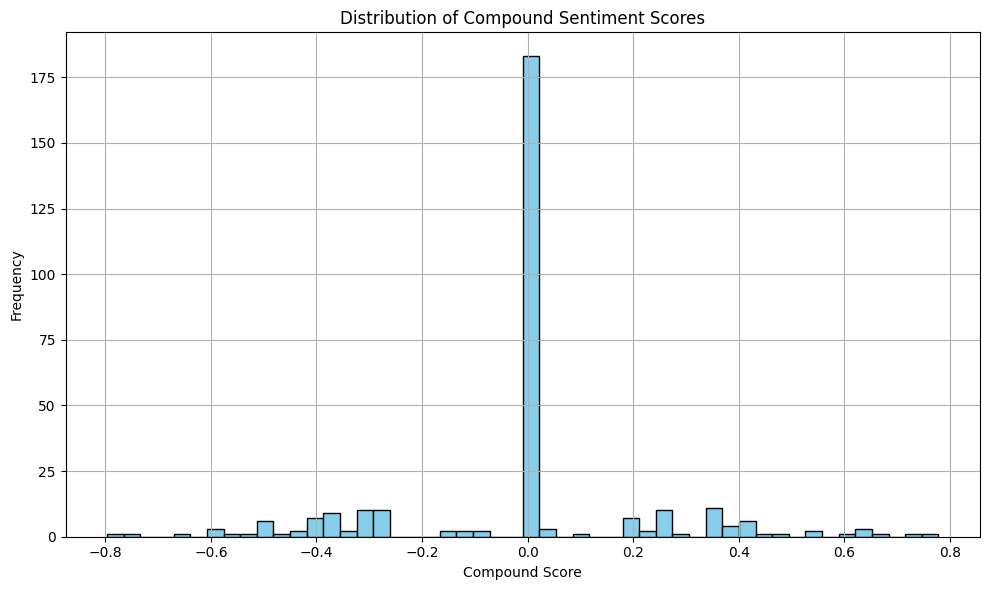

In [5]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt



# Load dataset
df = pd.read_csv("dataset/bitcoin_sentiment.csv")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Compute compound sentiment score
df['compound'] = df['post'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Plotting the sentiment score distribution
plt.figure(figsize=(10, 6))
plt.hist(df['compound'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()
# Optionally, save the updated DataFrame


df.to_csv("dataset/bitcoin_sentiment_scored.csv", index=False)

In [6]:
print(df['price_btc'])


0       84030.38
1       84030.38
2       84591.58
3       83760.00
4       83423.84
         ...    
295    102260.01
296    104556.23
297    104077.48
298     96560.86
299     94536.10
Name: price_btc, Length: 300, dtype: float64


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# True and predicted values for evaluation (excluding forecast)
true_values = price_series.values[seq_len+1:]
predicted_values = final_predicted_price

# Evaluation metrics
mae = mean_absolute_error(true_values, predicted_values)
rmse = np.sqrt(mean_squared_error(true_values, predicted_values))
r2 = r2_score(true_values, predicted_values)
mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
pseudo_accuracy = 100 - mape



# Print the scores
print("Model Evaluation Metrics:")
print(f"MAE (Mean Absolute Error): {mae:.6f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
print(f"R² Score: {r2:.6f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
print(f"Pseudo Accuracy: {pseudo_accuracy:.2f}%")


Model Evaluation Metrics:
MAE (Mean Absolute Error): 1974.638890
RMSE (Root Mean Squared Error): 2629.305171
R² Score: 0.897926
MAPE (Mean Absolute Percentage Error): 2.19%
Pseudo Accuracy: 97.81%


# Explanation
Mean Absolute Error (MAE): 1974.64
→ On average, the model’s predictions are approximately $1,975 away from the actual BTC prices. This is a reasonable error margin considering BTC’s high volatility.

Root Mean Squared Error (RMSE): 2629.31
→ A slightly higher error measure that penalizes large deviations. The RMSE shows that significant prediction errors are relatively rare.

R² Score: 0.8979
→ The model explains approximately 89.8% of the variance in the actual BTC prices. This indicates a very strong fit, particularly in financial time series forecasting.

Mean Absolute Percentage Error (MAPE): 2.19%
→ The model’s predictions deviate from the actual values by only 2.19% on average, which demonstrates high predictive accuracy.

Pseudo Accuracy (100 - MAPE): 97.81%
→ Although not a standard metric, this gives an intuitive sense of overall prediction accuracy.

- The hybrid model is performing very well in terms of predictive accuracy, especially in a domain as unpredictable as cryptocurrency markets.

- The low MAPE and high R² score indicate that the model effectively captures both price trends and the impact of sentiment on BTC value.

- These results suggest the model is suitable for short- to mid-term price forecasting and can be further fine-tuned for real-time applications or integrated into trading strategies.